<a href="https://www.iso-ne.com/"><img src="https://www.iso-ne.com/static-assets/img/iso-logo-gray-188x90.jpg" width="200" align="center"></a>

<h2><center>Relevance Vector
Machines for Electricity Pricing Signal
Forecasting</center></h2>

Price-directed demand in smart grids operating
within deregulated electricity markets calls for real-time fore-
casting of the price of electricity for the purpose of scheduling
demand at the nodal level (e.g., appliances, machines, and devices)
in a way that minimizes energy cost to the consumer. In this
paper, a novel hybrid methodology for electricity price forecast-
ing is introduced and applied on a set of real-world historical
data taken from the New England area. 

The proposed approach
is implemented in two steps. In the first step, a set of relevance
vector machines (RVMs) is adopted, where each RVM is used
for individual ahead-of-time price prediction. In the second step,
individual predictions are aggregated to formulate a linear regres-
sion ensemble, whose coefficients are obtained as the solution of
a single objective optimization problem. Thus, an optimal solution
to the problem is found by employing the micro-genetic algorithm
and the optimized ensemble is employed for computing the final
price forecast. 

The performance of the proposed methodology
is compared with performance of autoregressive-moving-average
and naïve forecasting methods, as well as to that taken from
each individual RVM. Results clearly demonstrate the superi-
ority of the hybrid methodology over the other tested methods
with regard to mean absolute error for electricity signal pricing
forecasting.

<h1>Table of contents</h1>

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ul>
        <li><a href="#random_generated_dataset">Importing the New England Data</a></li>
            <ol>
                <li><a href="#setting_up_K_means">Dataset</a></li>
                <li><a href="#creating_visual_plot">Viewing the data</a></li>
            </ol>
        <li><a href="#customer_segmentation_K_means">Visuvalizing the data</a></li>
            <ol>
                <li><a href="#pre_processing">Relevence Vector Machine</a></li>
                <li><a href="#modeling">ARIMA</a></li>
                <li><a href="#insights">Forecasting </a></li>
            </ol>
    </ul>
</div>
<br>
<hr>

Increasing competition among electricity providers in
a price-directed market adds stochasticity to pricing signals.
As a result, pricing signal forecasting consists of an essen-
tial tool for market participants to maximize their profit. For
instance, embedding price forecasting technology in smart
metering devices allows for residential customers to roughly
plan their load purchasing strategy prior to observing pricing
signals.

<img src="https://blog.greenenergyconsumers.org/hubfs/Artboard%20209@2x.png">

#### `Importing the Libraries`

In [169]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas.util.testing as tm

Data Imported from the ISO New England Energy consumption Load data.

In [170]:
#https://www.iso-ne.com/isoexpress/web/reports/load-and-demand/-/tree/whlsecost-hourly-system
data_cost=pd.read_csv("/home/shyam/Documents/Sushant Project/Ecost.csv")

In [171]:
data_cost.head()

H Location ID  Local Date Local Hour OnOffPeak Total Cost       RTLO
0  H      Number        Date     Number    String     Number     Number
1  D        4000  02/01/2021          1       OFF      66.31  13151.756
2  D        4000  02/01/2021          2       OFF      63.29  12856.046
3  D        4000  02/01/2021          3       OFF      57.83   12855.92
4  D        4000  02/01/2021          4       OFF      60.63   13059.28

Dropping the first row in the data, to which is not required.

In [172]:
data_cost.drop(0,axis=0,inplace=True)

To view the unique timing for 24 hours

In [173]:
data_cost['Local Hour'].unique()

array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', nan], dtype=object)

To display the date and time and then further make it an index

In [174]:
# Create datetimes
data_cost['Local Date'] = pd.date_range('02/01/2021', periods = 673, freq ='H')
  
print(data_cost.head(5))
  
# Select observations between two datetimes
x = data_cost[(data_cost['Local Date'] > '2012-1-2 01:00:00') &
       (data_cost['Local Date'] <= '2012-1-2 11:00:00')]
  
print(x)
pd.DataFrame(x)

   H Location ID          Local Date Local Hour OnOffPeak Total Cost  \
1  D        4000 2021-02-01 00:00:00          1       OFF      66.31   
2  D        4000 2021-02-01 01:00:00          2       OFF      63.29   
3  D        4000 2021-02-01 02:00:00          3       OFF      57.83   
4  D        4000 2021-02-01 03:00:00          4       OFF      60.63   
5  D        4000 2021-02-01 04:00:00          5       OFF      56.86   

        RTLO  
1  13151.756  
2  12856.046  
3   12855.92  
4   13059.28  
5  13385.385  
Empty DataFrame
Columns: [H, Location ID, Local Date, Local Hour, OnOffPeak, Total Cost, RTLO]
Index: []


Empty DataFrame
Columns: [H, Location ID, Local Date, Local Hour, OnOffPeak, Total Cost, RTLO]
Index: []

To view the datatypes for all the column

In [175]:
data_cost.dtypes

H                      object
Location ID            object
Local Date     datetime64[ns]
Local Hour             object
OnOffPeak              object
Total Cost             object
RTLO                   object
dtype: object

In [176]:
data_cost.isnull().sum()

H              0
Location ID    0
Local Date     0
Local Hour     1
OnOffPeak      1
Total Cost     1
RTLO           1
dtype: int64

Drop the null values in the data

In [177]:
data_cost.dropna(inplace=True)

In [178]:
data_cost.isnull().sum()

H              0
Location ID    0
Local Date     0
Local Hour     0
OnOffPeak      0
Total Cost     0
RTLO           0
dtype: int64

#### `Relevance Vector Machine`

Relevance Vector Machine (RVM) is a supervised learning algorithm extended from Support Vector Machine (SVM) based on the Bayesian sparsity model. Compared with the regression problem, RVM classification is difficult to be conducted because there is no closed-form solution for the weight parameter posterior. Original RVM classification algorithm used Newton's method in optimization to obtain the mode of weight parameter posterior then approximated it by a Gaussian distribution in Laplace's method. It would work but just applied the frequency methods in a Bayesian framework. 

Importing the model Relevence Vector machine

In [179]:
from sklearn_rvm import EMRVR

In [32]:
#pip install sklearn-rvm --user

In [180]:
data_cost.head()

H Location ID          Local Date Local Hour OnOffPeak Total Cost  \
1  D        4000 2021-02-01 00:00:00          1       OFF      66.31   
2  D        4000 2021-02-01 01:00:00          2       OFF      63.29   
3  D        4000 2021-02-01 02:00:00          3       OFF      57.83   
4  D        4000 2021-02-01 03:00:00          4       OFF      60.63   
5  D        4000 2021-02-01 04:00:00          5       OFF      56.86   

        RTLO  
1  13151.756  
2  12856.046  
3   12855.92  
4   13059.28  
5  13385.385

In [39]:
data_cost=data_cost.dropna()

To make the column as numeric data

In [181]:
data_cost['Total Cost']=pd.to_numeric(data_cost['Total Cost'])
data_cost['RTLO']=pd.to_numeric(data_cost['RTLO'])

Independent variable and dependent variable

In [182]:
X=data_cost.loc[:,'RTLO':'RTLO']
y=data_cost.loc[:,'Total Cost']

Training and testing Proces 

In [224]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20)

In [225]:
X_train.shape

(537, 1)

In [226]:
X_test.shape

(135, 1)

In [227]:
y_train.shape

(537,)

In [228]:
y_test.shape

(135,)

In [242]:
# Fit RVR-- Relevence Vector Machine
rvr = EMRVR(kernel="linear")
#stime = time.time()
rvr.fit(X_train, y_train)
#print("Time for RVR fitting: %.3f" % (time.time() - stime))

/home/shyam/.local/lib/python3.7/site-packages/sklearn_rvm/em_rvm.py:324: UserWarning:

Hessian not positive definite



Machine Predicting the output of the Independent test data

In [243]:
y_pred=rvr.predict(X_test)

In [244]:
y_pred

array([120.90701454, 100.02644315,  48.41998061, 106.41671136,
        89.56744094,  50.64952206,  79.20132274,  83.73259792,
       101.9598566 , 108.51701974,  84.73652088,  45.83536738,
        50.89259586,  75.45722511,  82.55410794,  82.1808496 ,
        69.19085444,  96.62834809,  66.9229646 ,  95.70360297,
        57.26376214,  71.2683995 ,  96.44002672,  57.68972542,
       104.85565295, 106.69036509,  67.24549325,  80.78919129,
        87.37299596,  61.32276452, 106.91848013,  71.46880109,
        75.93913318,  72.00640102,  70.75458663,  91.06190758,
        69.88054713,  48.79339553,  63.14727532, 112.13688261,
        53.88231201,  80.81807302, 105.00669786,  84.96993532,
        58.6301399 ,  67.09271399,  58.50715771,  98.5111041 ,
        58.67999039,  82.33777203,  85.87563874,  80.73782326,
        74.3478682 ,  81.9811827 , 110.12810929,  59.17112423,
        84.13797786,  92.82673993, 104.47503566,  66.03888033,
       104.81993018,  94.72764638,  93.2051411 , 101.47

In [245]:
rvr.predict([[13151.756]])

array([66.96496234])

In [240]:
y_pred

array([ 73.98547638,  73.98547729,  73.98547638,  74.16432125,
        73.98547692,  73.98404731,  91.16683205,  73.98547638,
        74.03547658,  73.98547638,  73.98547638,  73.98547638,
        59.43840977,  73.98547417,  77.88189211,  73.98547638,
        91.90475282,  73.98547641,  74.04269241,  92.27316036,
        69.57763651,  73.98569518,  74.2844735 ,  74.03856289,
        75.40978836,  74.09012386,  73.98547638,  73.98547638,
        73.98547638,  73.9855149 ,  73.98547638,  73.98547638,
        73.98547638,  73.98547638,  70.51370599,  71.23510269,
        73.98547638,  73.98547638,  73.98547638,  73.98547638,
        73.98547638,  73.98547638,  73.98547638,  73.98547638,
        73.98547637,  73.98547638,  73.98547634,  73.99105785,
        73.98547638,  73.98547638,  76.41301964,  73.98547638,
        73.98547638,  73.98547638,  73.98547638,  73.98217833,
        73.98547638,  78.20202337,  82.16260353,  73.98547572,
        80.72421573,  90.05843012,  67.63735995,  74.65

Error for each and every random date and time 

In [246]:
y_test-y_pred

211   -17.467015
252   -10.306443
652    -4.199981
421     8.113289
304    -1.357441
         ...    
576   -26.319992
639   -27.948784
196     8.534301
128    -2.879455
230    -4.822651
Name: Total Cost, Length: 135, dtype: float64

In [271]:
from sklearn.metrics import mean_absolute_error

To view the Residual histograms whether it si normally distributed

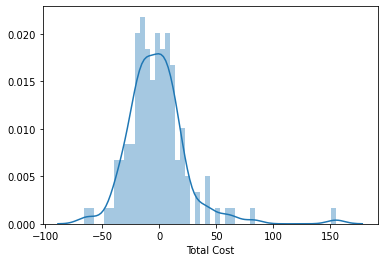

In [214]:
sns.distplot((y_test-y_pred),bins=50)

In [272]:
mean_absolute_error(y_test,y_pred)

17.957482768328614

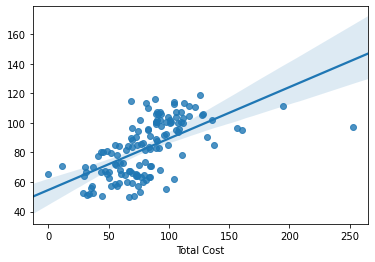

In [47]:
sns.regplot(y_test,y_pred)

> #### `Navie Bayes Regression`

In [263]:
from sklearn.linear_model import BayesianRidge

In [265]:
naviee = BayesianRidge()
naviee.fit(X_train, y_train)

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
              fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
              normalize=False, tol=0.001, verbose=False)

In [267]:
y_prednav=naviee.predict(X_test)

For each and every date and time , errors displaying

In [269]:
y_test-y_prednav

211   -17.769859
252   -10.434098
652    -3.894652
421     7.932019
304    -1.397344
         ...    
576   -26.046714
639   -27.911425
196     8.699215
128    -2.762983
230    -4.937773
Name: Total Cost, Length: 135, dtype: float64

> #### `ARIMA Forecasting`

ARIMA, short for 'Auto Regressive Integrated Moving Average' is actually a class of models that 'explains' a given time series based on its own past values, that is, its own lags and the lagged forecast errors, so that equation can be used to forecast future values.

In [249]:
data_cost['Local Date']=pd.to_datetime(data_cost['Local Date'])

In [250]:
data_cost.head()

H Location ID          Local Date Local Hour OnOffPeak  Total Cost  \
1  D        4000 2021-02-01 00:00:00          1       OFF       66.31   
2  D        4000 2021-02-01 01:00:00          2       OFF       63.29   
3  D        4000 2021-02-01 02:00:00          3       OFF       57.83   
4  D        4000 2021-02-01 03:00:00          4       OFF       60.63   
5  D        4000 2021-02-01 04:00:00          5       OFF       56.86   

        RTLO  
1  13151.756  
2  12856.046  
3  12855.920  
4  13059.280  
5  13385.385

In [251]:
data_cost.dtypes

H                      object
Location ID            object
Local Date     datetime64[ns]
Local Hour             object
OnOffPeak              object
Total Cost            float64
RTLO                  float64
dtype: object

Setting the index as Date and time 

In [253]:
indexedDataset=data_cost.set_index(['Local Date'])

Not Required columns can be dropped

In [254]:
indexedDatasetload=indexedDataset.drop(['H','Location ID','Local Hour','OnOffPeak','RTLO'],axis=1)

To visuvalize the data energy price with date 

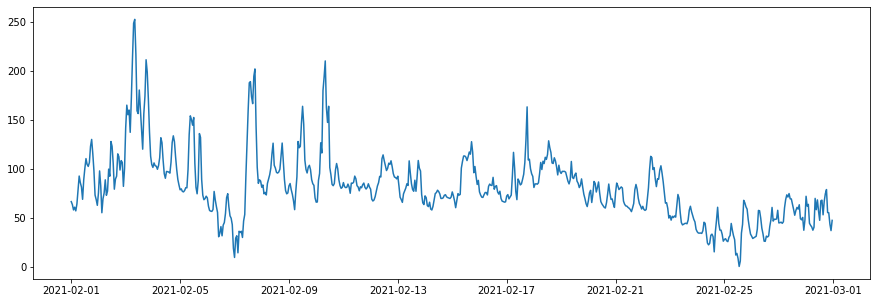

In [255]:
plt.figure(figsize=(15,5))
plt.plot(indexedDatasetload)

To visuvalize with 24 hours timing , energy price 

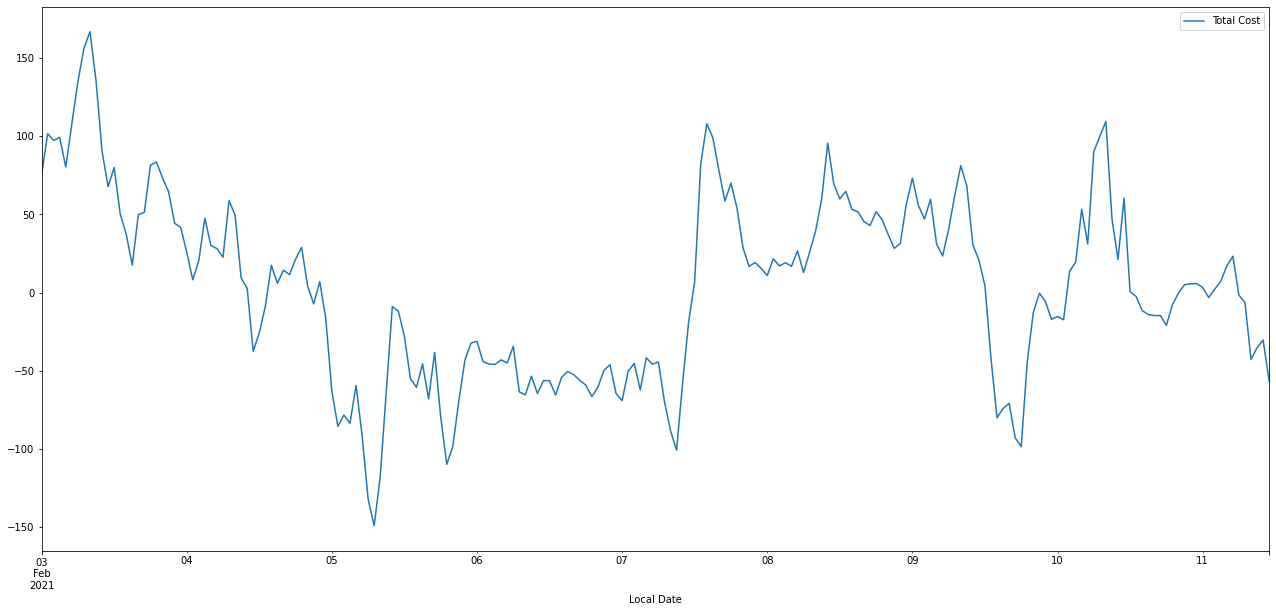

In [257]:
from datetime import datetime, timedelta
#seasonal differencing by 24 hours, 48 observations and plotting it
start_date = datetime(2021,2,1,11,0,0)
period = 10  # observing prices for a period of 10 days
end_date = start_date + timedelta(days = period)
diff_price_series = indexedDatasetload.diff(periods = 48)
diff_price_series.dropna()[start_date:end_date].plot(figsize = (22,10))
plt.legend()
plt.show()

To view the distribution of the data kernel density estimator 

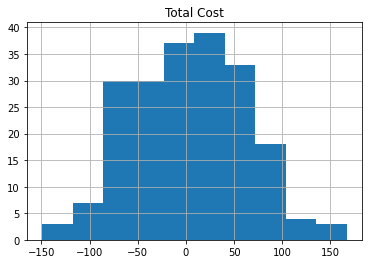

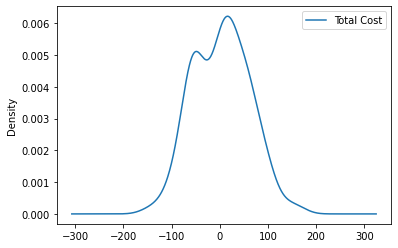

In [259]:
#plotting histogram and kernel density function for the given time series
diff_price_series[start_date:end_date].hist()
diff_price_series[start_date:end_date].plot.density()
plt.show()


To view the statistics skewness in the Energy price 

In [260]:
indexedDataset['Total Cost'].skew()

1.1520955562490527

Visuvalizing with Range Slider 

In [64]:
import plotly.express as px
import plotly.graph_objects as go
#df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/finance-charts-apple.csv')

fig = px.line(data_cost, x='Local Date', y='Total Cost', title='Time Series with Rangeslider')

fig.update_xaxes(rangeslider_visible=True)
fig.show()

As the Load is crossing 17k, it is energy price is fluctuating and it is increasing/per hour rate.

In [136]:
data_cost.head(24)

H Location ID          Local Date Local Hour OnOffPeak  Total Cost  \
1   D        4000 2021-02-01 00:00:00          1       OFF       66.31   
2   D        4000 2021-02-01 01:00:00          2       OFF       63.29   
3   D        4000 2021-02-01 02:00:00          3       OFF       57.83   
4   D        4000 2021-02-01 03:00:00          4       OFF       60.63   
5   D        4000 2021-02-01 04:00:00          5       OFF       56.86   
6   D        4000 2021-02-01 05:00:00          6       OFF       63.96   
7   D        4000 2021-02-01 06:00:00          7       OFF       77.70   
8   D        4000 2021-02-01 07:00:00          8        ON       92.46   
9   D        4000 2021-02-01 08:00:00          9        ON       85.72   
10  D        4000 2021-02-01 09:00:00         10        ON       81.26   
11  D        4000 2021-02-01 10:00:00         11        ON       68.68   
12  D        4000 2021-02-01 11:00:00         12        ON       88.55   
13  D        4000 2021-02-01 12:00:00         13        ON      100.33   
14  D        4000 2021-02-01 13:00:00         14        ON      110.27   
15  D        4000 2021-02-01 14:00:00         15        ON      104.27   
16  D        4000 2021-02-01 15:00:00         16        ON      102.31   
17  D        4000 2021-02-01 16:00:00         17        ON      106.34   
18  D        4000 2021-02-01 17:00:00         18        ON      122.78   
19  D        4000 2021-02-01 18:00:00         19        ON      129.88   
20  D        4000 2021-02-01 19:00:00         20        ON      115.39   
21  D        4000 2021-02-01 20:00:00         21        ON       98.02   
22  D        4000 2021-02-01 21:00:00         22        ON       73.00   
23  D        4000 2021-02-01 22:00:00         23        ON       68.42   
24  D        4000 2021-02-01 23:00:00         24       OFF       62.54   

         RTLO  
1   13151.756  
2   12856.046  
3   12855.920  
4   13059.280  
5   13385.385  
6   13970.121  
7   15119.921  
8   16187.680  
9   16831.895  
10  17093.072  
11  17241.884  
12  17327.902  
13  17318.994  
14  17232.127  
15  17035.815  
16  16919.241  
17  17231.167  
18  17878.178  
19  17559.027  
20  16846.306  
21  15990.753  
22  15031.068  
23  14010.025  
24  13320.782

Rolling Mean and Rolling Standard Deviation

In [65]:
rolmean=indexedDatasetload.rolling(window=12).mean()
rolstd=indexedDatasetload.rolling(window=12).std()
print(rolmean,rolstd)

                     Total Cost
Local Date                     
2021-02-01 00:00:00         NaN
2021-02-01 01:00:00         NaN
2021-02-01 02:00:00         NaN
2021-02-01 03:00:00         NaN
2021-02-01 04:00:00         NaN
...                         ...
2021-02-28 19:00:00   63.523333
2021-02-28 20:00:00   62.305833
2021-02-28 21:00:00   61.086667
2021-02-28 22:00:00   58.473333
2021-02-28 23:00:00   57.685833

[672 rows x 1 columns]                      Total Cost
Local Date                     
2021-02-01 00:00:00         NaN
2021-02-01 01:00:00         NaN
2021-02-01 02:00:00         NaN
2021-02-01 03:00:00         NaN
2021-02-01 04:00:00         NaN
...                         ...
2021-02-28 19:00:00    9.412034
2021-02-28 20:00:00    9.496268
2021-02-28 21:00:00   10.918014
2021-02-28 22:00:00   12.699702
2021-02-28 23:00:00   13.112050

[672 rows x 1 columns]


Text(0.5, 1.0, 'Rolling mean and standard deviation')

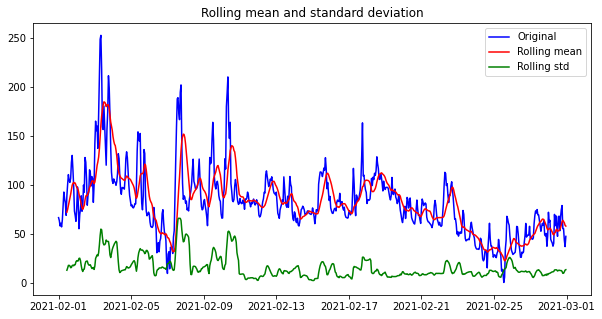

In [66]:
plt.figure(figsize=(10,5))
orig=plt.plot(indexedDatasetload, color='blue', label='Original')
mean=plt.plot(rolmean, color='red', label='Rolling mean')
std=plt.plot(rolstd, color='green', label='Rolling std')
plt.legend(loc='best')
plt.title('Rolling mean and standard deviation')
#plt.show(block=False)

To identify the nature of data, we will be using the null hypothesis.

H0: The null hypothesis: It is a statement about the population that either is believed to be true or is used to put forth an argument unless it can be shown to be incorrect beyond a reasonable doubt.

H1: The alternative hypothesis: It is a claim about the population that is contradictory to H0 and what we conclude when we reject H0.

#Ho: It is non-stationary
#H1: It is stationary
We will be considering the null hypothesis that data is not stationary and the alternate hypothesis that data is stationary.



In [138]:
from statsmodels.tsa.stattools import adfuller

In [141]:
test_result=adfuller(data_cost['Total Cost'])

In [142]:
test_result

(-4.987146377693439,
 2.3530494565002256e-05,
 3,
 668,
 {'1%': -3.4401772556197705,
  '5%': -2.865876419242622,
  '10%': -2.569079289056617},
 5105.431645808443)

Statistically to view the p-value to accept or reject hypothesis

In [144]:
def adfuller_test(price):
    result=adfuller(price)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

In [146]:
adfuller_test(data_cost['Total Cost'])

ADF Test Statistic : -4.987146377693439
p-value : 2.3530494565002256e-05
#Lags Used : 3
Number of Observations : 668


In [149]:
result=adfuller(data_cost['Total Cost'])

if result[1] <= 0.05:
    print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
else:
    print("weak evidence against null hypothesis,indicating it is non-stationary ")



strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


In [150]:
data_cost['Cost First Difference'] = data_cost['Total Cost'] - data_cost['Total Cost'].shift(1)
data_cost['Seasonal First Difference']=data_cost['Total Cost']-data_cost['Total Cost'].shift(12)
data_cost.head()

H Location ID          Local Date Local Hour OnOffPeak  Total Cost  \
1  D        4000 2021-02-01 00:00:00          1       OFF       66.31   
2  D        4000 2021-02-01 01:00:00          2       OFF       63.29   
3  D        4000 2021-02-01 02:00:00          3       OFF       57.83   
4  D        4000 2021-02-01 03:00:00          4       OFF       60.63   
5  D        4000 2021-02-01 04:00:00          5       OFF       56.86   

        RTLO  Cost First Difference  Seasonal First Difference  
1  13151.756                    NaN                        NaN  
2  12856.046                  -3.02                        NaN  
3  12855.920                  -5.46                        NaN  
4  13059.280                   2.80                        NaN  
5  13385.385                  -3.77                        NaN

In [151]:
# Again testing if data is stationary
adfuller_test(data_cost['Seasonal First Difference'].dropna())

ADF Test Statistic : -5.854623774624029
p-value : 3.5237186698821986e-07
#Lags Used : 13
Number of Observations : 646


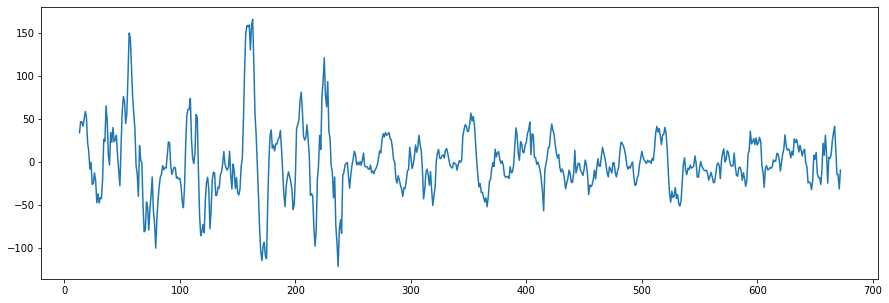

In [154]:
plt.figure(figsize=(15,5))
data_cost['Seasonal First Difference'].plot();

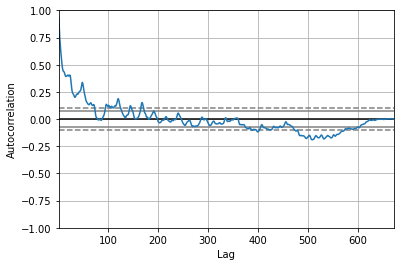

In [155]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(data_cost['Total Cost'])
plt.show()

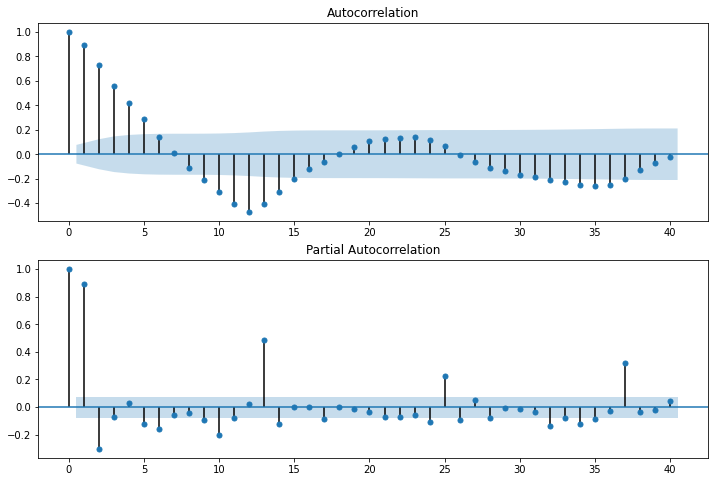

In [156]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data_cost['Seasonal First Difference'].dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data_cost['Seasonal First Difference'].dropna(),lags=40,ax=ax2)

In [157]:
# For non-seasonal data
#p=1, d=1, q=0 or 1

from statsmodels.tsa.arima_model import ARIMA
model=ARIMA(data_cost['Total Cost'],order=(1,1,1))
model_fit=model.fit()
model_fit.summary()

/home/shyam/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/home/shyam/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.



<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:           D.Total Cost   No. Observations:                  671
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2643.954
Method:                       css-mle   S.D. of innovations             12.445
Date:                Fri, 09 Apr 2021   AIC                           5295.908
Time:                        10:08:46   BIC                           5313.943
Sample:                             1   HQIC                          5302.893
                                                                              
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0250      0.600     -0.042      0.967      -1.202       1.152
ar.L1.D.Total Cost     0.0357      0.115      0.311      0.756      -0.189       0.260
ma.L1.D.Total Cost     0.2053      0.109      1.885      0.060      -0.008       0.419
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           28.0120           +0.0000j           28.0120            0.0000
MA.1           -4.8702           +0.0000j            4.8702            0.5000
-----------------------------------------------------------------------------
"""

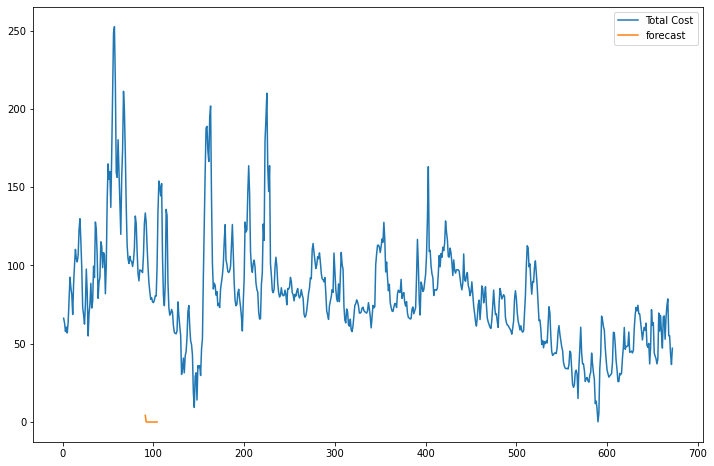

In [159]:
data_cost['forecast']=model_fit.predict(start=90,end=103,dynamic=True)
data_cost[['Total Cost','forecast']].plot(figsize=(12,8));

/home/shyam/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/home/shyam/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



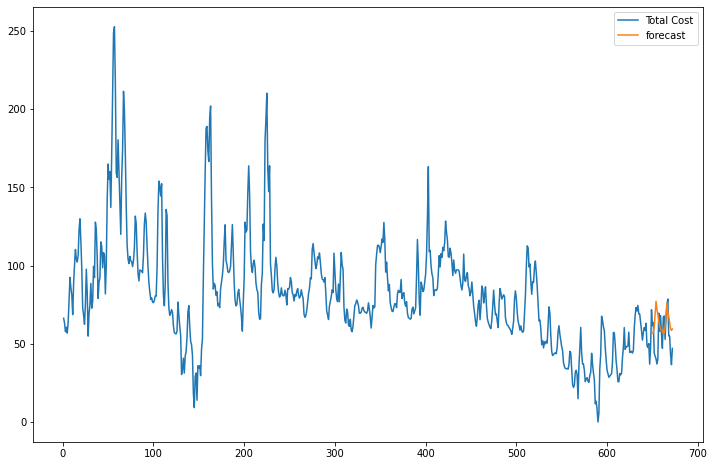

In [162]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(data_cost['Total Cost'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()
data_cost['forecast']=results.predict(start=650,end=700,dynamic=True)
data_cost[['Total Cost','forecast']].plot(figsize=(12,8))

In [164]:
# Dickey filler test

from statsmodels.tsa.stattools import adfuller

print('Results')
dftest=adfuller(indexedDataset['Total Cost'], autolag='t-stat') #https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html

dfoutput=pd.Series(dftest[0:4], index=['test statistic','p value','Lags used','Number of observations'])   # [0:4 ] defines first four values passengers dataset as sample 
for key, value in dftest[4].items():
    dfoutput['Critical value(%s)'%key]=value
    
print(dfoutput)

Results
test statistic             -2.686525
p value                     0.076399
Lags used                  17.000000
Number of observations    654.000000
Critical value(1%)         -3.440388
Critical value(5%)         -2.865969
Critical value(10%)        -2.569129
dtype: float64


Logarthemic Scaling to make the data stationary and can forecast

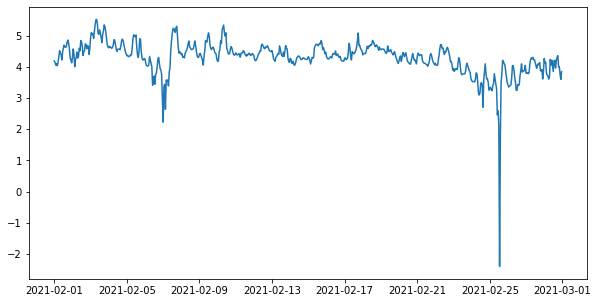

In [165]:
#estimating trend
plt.figure(figsize=(10,5))
indexedDataset_logScale=np.log(indexedDatasetload)
plt.plot(indexedDataset_logScale)

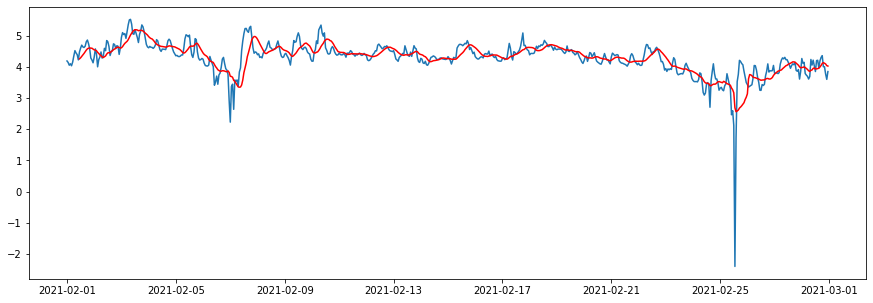

In [166]:
plt.figure(figsize=(15,5))
movingaverage=indexedDataset_logScale.rolling(window=12).mean()
movingstd=indexedDataset_logScale.rolling(window=12).std()
plt.plot(indexedDataset_logScale)
plt.plot(movingaverage, color='red')

In [70]:
datasetlogscaleminusmovingaverage=indexedDataset_logScale - movingaverage
datasetlogscaleminusmovingaverage.head(12)

datasetlogscaleminusmovingaverage.dropna(inplace=True)
datasetlogscaleminusmovingaverage.head(10)

Total Cost
Local Date                     
2021-02-01 11:00:00    0.221516
2021-02-01 12:00:00    0.311903
2021-02-01 13:00:00    0.360103
2021-02-01 14:00:00    0.255032
2021-02-01 15:00:00    0.192455
2021-02-01 16:00:00    0.178918
2021-02-01 17:00:00    0.268326
2021-02-01 18:00:00    0.281730
2021-02-01 19:00:00    0.144975
2021-02-01 20:00:00   -0.029345

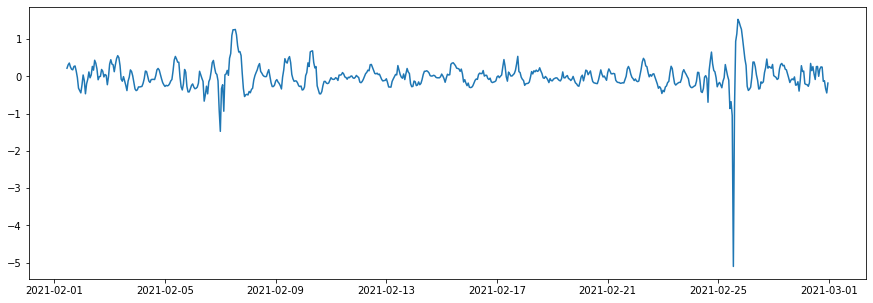

In [71]:
plt.figure(figsize=(15,5))
plt.plot(datasetlogscaleminusmovingaverage)

In [72]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    movingaverage=timeseries.rolling(window=12).mean()
    movingstd=timeseries.rolling(window=12).std()

    orig=plt.plot(timeseries, color='blue', label='Original')
    mean=plt.plot(movingaverage, color='red', label='Rollingmean')
    std=plt.plot(movingstd, color='black', label='Rollingstd')
    plt.legend(loc='best')
    plt.title("Rolling meand and std")
    plt.show(block=False)
    
    print("Results of df test")
    dftest=adfuller(timeseries["Total Cost"], autolag='AIC')
    dfoutput=pd.Series(dftest[0:4], index=['Test Statistics','pvalue','lags','number of observations'])
    for key, value in dftest[4].items():
        dfoutput['critical value(%s)'%key]= value
    print(dfoutput)
    

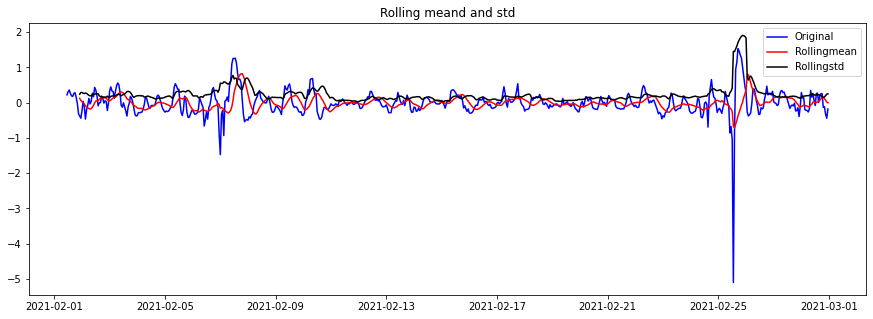

Results of df test
Test Statistics          -1.071973e+01
pvalue                    3.173517e-19
lags                      6.000000e+00
number of observations    6.540000e+02
critical value(1%)       -3.440388e+00
critical value(5%)       -2.865969e+00
critical value(10%)      -2.569129e+00
dtype: float64


In [73]:
plt.figure(figsize=(15,5))
test_stationarity(datasetlogscaleminusmovingaverage)

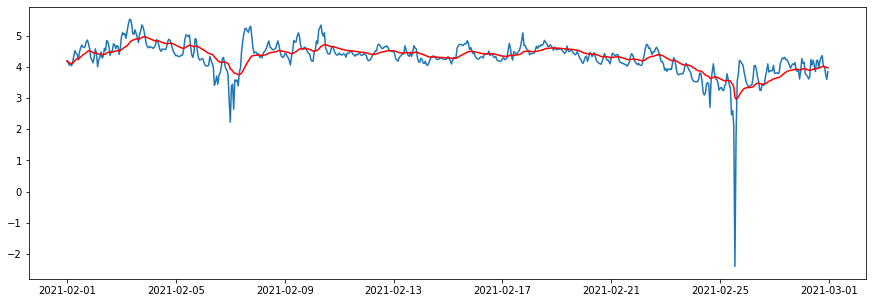

In [74]:
plt.figure(figsize=(15,5))
exponentialdecayweightedaverage=indexedDataset_logScale.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(indexedDataset_logScale)
plt.plot(exponentialdecayweightedaverage , color='red')

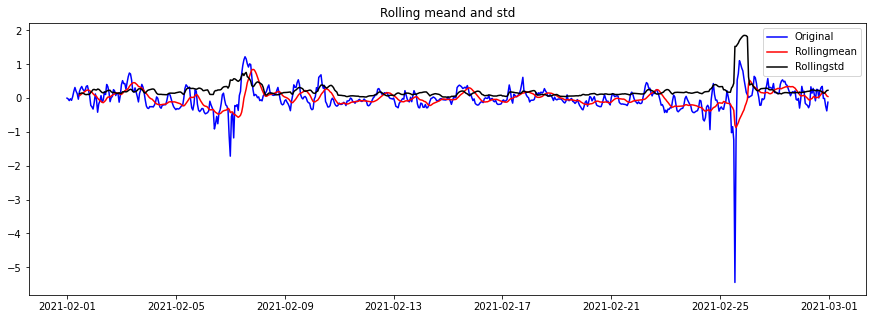

Results of df test
Test Statistics          -9.558633e+00
pvalue                    2.459910e-16
lags                      3.000000e+00
number of observations    6.680000e+02
critical value(1%)       -3.440177e+00
critical value(5%)       -2.865876e+00
critical value(10%)      -2.569079e+00
dtype: float64


In [75]:
plt.figure(figsize=(15,5))
datasetlogscaleminusmovingexponentialdecayavg=indexedDataset_logScale - exponentialdecayweightedaverage
test_stationarity(datasetlogscaleminusmovingexponentialdecayavg)

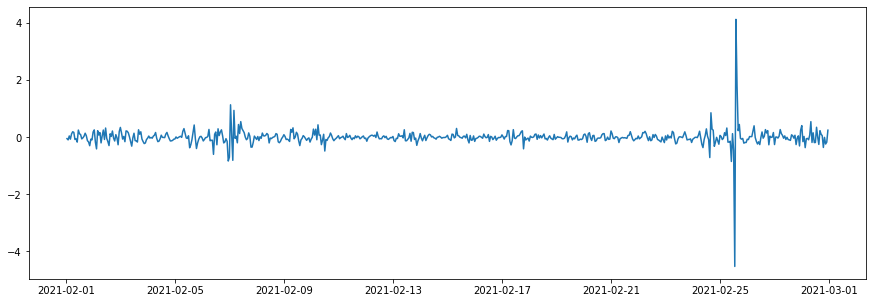

In [76]:
plt.figure(figsize=(15,5))
datasetLogdiffshifting=indexedDataset_logScale - indexedDataset_logScale.shift()
plt.plot(datasetLogdiffshifting)

In [77]:
indexedDataset_logScale.shift().head()

Total Cost
Local Date                     
2021-02-01 00:00:00         NaN
2021-02-01 01:00:00    4.194341
2021-02-01 02:00:00    4.147727
2021-02-01 03:00:00    4.057508
2021-02-01 04:00:00    4.104790

In [78]:
datasetLogdiffshifting.head()

Total Cost
Local Date                     
2021-02-01 00:00:00         NaN
2021-02-01 01:00:00   -0.046613
2021-02-01 02:00:00   -0.090220
2021-02-01 03:00:00    0.047282
2021-02-01 04:00:00   -0.064198

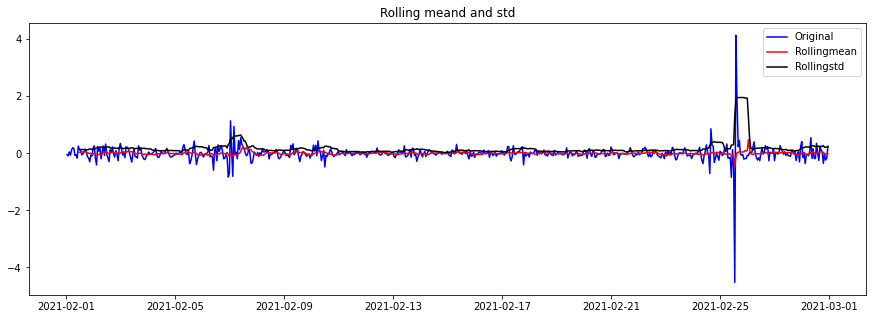

Results of df test
Test Statistics          -9.782635e+00
pvalue                    6.670369e-17
lags                      2.000000e+01
number of observations    6.500000e+02
critical value(1%)       -3.440450e+00
critical value(5%)       -2.865997e+00
critical value(10%)      -2.569143e+00
dtype: float64


In [79]:
plt.figure(figsize=(15,5))
datasetLogdiffshifting.dropna(inplace=True)
test_stationarity(datasetLogdiffshifting)

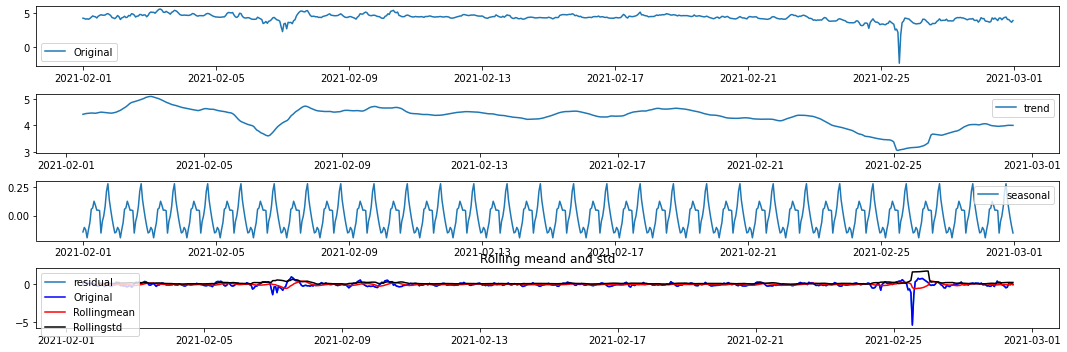

Results of df test
Test Statistics          -1.036950e+01
pvalue                    2.283706e-18
lags                      1.700000e+01
number of observations    6.300000e+02
critical value(1%)       -3.440772e+00
critical value(5%)       -2.866139e+00
critical value(10%)      -2.569219e+00
dtype: float64


In [81]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition= seasonal_decompose(indexedDataset_logScale)

trend= decomposition.trend
seasonal=decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(15,5))
plt.subplot(411)
plt.plot(indexedDataset_logScale, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='seasonal')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='residual')
plt.legend(loc='best')
plt.tight_layout()

decomposedLogdata=residual
decomposedLogdata.dropna(inplace=True)
test_stationarity(decomposedLogdata)


/home/shyam/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.



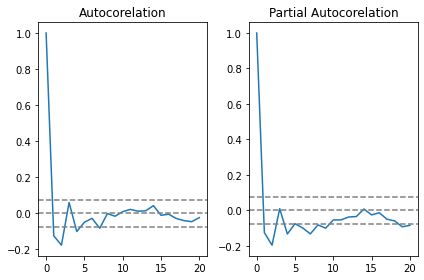

In [82]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf=acf(datasetLogdiffshifting, nlags=20)
lag_pacf=pacf(datasetLogdiffshifting, nlags=20, method='ols')
# http://www.math.armstrong.edu/statsonline/5/5.3.2.html   value 1.96 taken for 5%
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogdiffshifting)), linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogdiffshifting)), linestyle='--',color='gray')
plt.title('Autocorelation')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogdiffshifting)), linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogdiffshifting)), linestyle='--',color='gray')
plt.title('Partial Autocorelation')
plt.tight_layout()


/home/shyam/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.

/home/shyam/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.



AR plotting


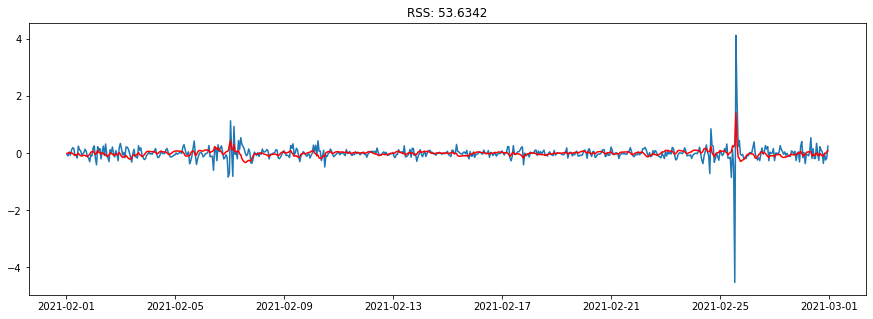

In [83]:
from statsmodels.tsa.arima_model import ARIMA

#AR model
plt.figure(figsize=(15,5))
model=ARIMA(indexedDataset_logScale, order=(1,1,1))
results_AR=model.fit(disp=-1)
plt.plot(datasetLogdiffshifting)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-datasetLogdiffshifting['Total Cost'])**2))
print("AR plotting")


/home/shyam/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.

/home/shyam/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.



ARIMA plotting


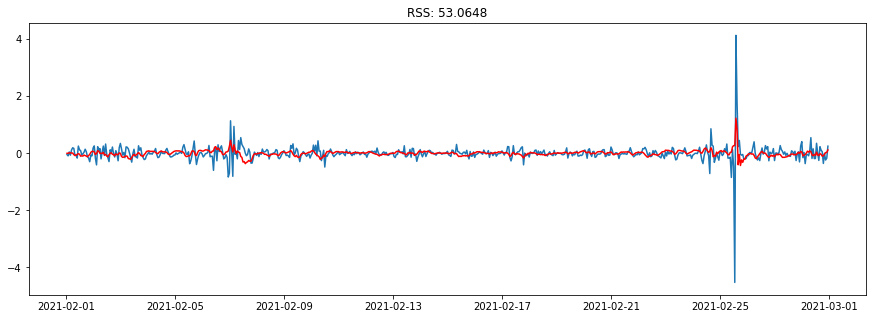

In [84]:
plt.figure(figsize=(15,5))
model=ARIMA(indexedDataset_logScale, order=(2,1,2))
results_ARIMA=model.fit(disp=-1)
plt.plot(datasetLogdiffshifting)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-datasetLogdiffshifting['Total Cost'])**2))
print("ARIMA plotting")

In [85]:
results_ARIMA.fittedvalues.head()

Local Date
2021-02-01 01:00:00   -0.000634
2021-02-01 02:00:00    0.003490
2021-02-01 03:00:00    0.017763
2021-02-01 04:00:00    0.015248
2021-02-01 05:00:00    0.011921
dtype: float64

To view the ARIMA Fitting vlaues

In [86]:
predictions_ARIMA_diff=pd.Series(results_ARIMA.fittedvalues, copy=False)
print(predictions_ARIMA_diff.head())

Local Date
2021-02-01 01:00:00   -0.000634
2021-02-01 02:00:00    0.003490
2021-02-01 03:00:00    0.017763
2021-02-01 04:00:00    0.015248
2021-02-01 05:00:00    0.011921
dtype: float64


In [87]:
# convert to cummulative sum

predictions_ARIMA_diff_cumsum=predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

Local Date
2021-02-01 01:00:00   -0.000634
2021-02-01 02:00:00    0.002855
2021-02-01 03:00:00    0.020618
2021-02-01 04:00:00    0.035867
2021-02-01 05:00:00    0.047787
dtype: float64


In [88]:
predictions_ARIMA_log=pd.Series(indexedDataset_logScale['Total Cost'], index=indexedDataset_logScale.index)


In [89]:
predictions_ARIMA_log.head()

Local Date
2021-02-01 00:00:00    4.194341
2021-02-01 01:00:00    4.147727
2021-02-01 02:00:00    4.057508
2021-02-01 03:00:00    4.104790
2021-02-01 04:00:00    4.040592
Name: Total Cost, dtype: float64

In [90]:
predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0).head()

Local Date
2021-02-01 00:00:00    4.194341
2021-02-01 01:00:00    4.147093
2021-02-01 02:00:00    4.060363
2021-02-01 03:00:00    4.125408
2021-02-01 04:00:00    4.076459
dtype: float64

In [126]:
predictions_ARIMA_log=pd.Series(indexedDataset_logScale['Total Cost'].iloc[0], index=indexedDataset_logScale.index)

predictions_ARIMA_log=predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

Local Date
2021-02-01 00:00:00    4.194341
2021-02-01 01:00:00    4.193706
2021-02-01 02:00:00    4.197196
2021-02-01 03:00:00    4.214959
2021-02-01 04:00:00    4.230207
dtype: float64

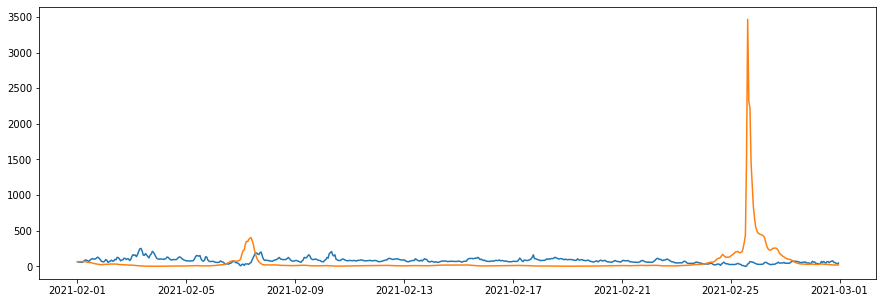

In [127]:
plt.figure(figsize=(15,5))
predictions_ARIMA=np.exp(predictions_ARIMA_log)
plt.plot(indexedDatasetload)
plt.plot(predictions_ARIMA);


In [128]:
indexedDataset_logScale.head()

Total Cost
Local Date                     
2021-02-01 00:00:00    4.194341
2021-02-01 01:00:00    4.147727
2021-02-01 02:00:00    4.057508
2021-02-01 03:00:00    4.104790
2021-02-01 04:00:00    4.040592

To view the Forecasting for next days , Confidence interval range

<Figure size 1080x360 with 0 Axes>

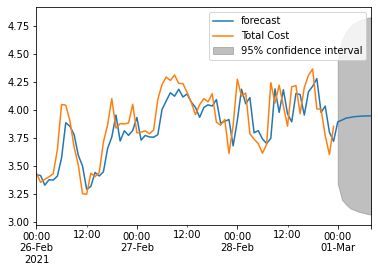

In [129]:
plt.figure(figsize=(15,5))
results_ARIMA.plot_predict(600,680)
x=results_ARIMA.forecast(steps=60);

In [125]:
results_ARIMA.forecast(steps=120)

(array([3.8945559 , 3.91004687, 3.92718293, 3.93372099, 3.94067705,
        3.94322503, 3.94583587, 3.94661044, 3.94736479, 3.94735304,
        3.9473135 , 3.94695383, 3.94657449, 3.94606119, 3.94553629,
        3.94495525, 3.94436795, 3.94375709, 3.94314303, 3.94251906,
        3.9418935 , 3.94126377, 3.94063328, 3.94000102, 3.93936841,
        3.93873505, 3.93810152, 3.93746768, 3.93683376, 3.9361997 ,
        3.93556561, 3.93493146, 3.9342973 , 3.93366311, 3.93302892,
        3.93239471, 3.9317605 , 3.93112629, 3.93049207, 3.92985786,
        3.92922364, 3.92858942, 3.9279552 , 3.92732099, 3.92668677,
        3.92605255, 3.92541833, 3.92478411, 3.92414989, 3.92351567,
        3.92288145, 3.92224723, 3.92161301, 3.9209788 , 3.92034458,
        3.91971036, 3.91907614, 3.91844192, 3.9178077 , 3.91717348,
        3.91653926, 3.91590504, 3.91527082, 3.9146366 , 3.91400238,
        3.91336817, 3.91273395, 3.91209973, 3.91146551, 3.91083129,
        3.91019707, 3.90956285, 3.90892863, 3.90

**References**:

https://www.iso-ne.com/isoexpress/web/reports/load-and-demand/-/tree/whlsecost-hourly-system  **Real timedata New England Load and demand price** 

https://en.wikipedia.org/wiki/Relevance_vector_machine   **Relevence Vector Machine**

https://en.wikipedia.org/wiki/Time_series   **Forecasting ARIMA**